In [312]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from matplotlib.lines import lineStyles
import requests
import time
import csv

In [313]:
pH = ctrl.Antecedent(np.arange(0, 15, 0.1), 'pH')
pH['Low'] = fuzz.trimf(pH.universe, [0, 0, 7])
pH['Optimal'] = fuzz.trimf(pH.universe, [6, 7, 8])
pH['High'] = fuzz.trimf(pH.universe, [7, 14, 14])

In [314]:
airTemp = ctrl.Antecedent(np.arange(0, 46, 1), 'AirTemp')
airTemp['Low'] = fuzz.trimf(airTemp.universe, [0, 0, 15])
airTemp['Optimal'] = fuzz.trimf(airTemp.universe, [10, 15, 20])
airTemp['High'] = fuzz.trimf(airTemp.universe, [15, 45, 45])

In [315]:
humidity = ctrl.Antecedent(np.arange(0,101,1), 'Humidity')
humidity['Low'] = fuzz.trimf(humidity.universe, [0, 0, 60])
humidity['Optimal'] = fuzz.trimf(humidity.universe, [50, 60, 70])
humidity['High'] = fuzz.trimf(humidity.universe, [60, 100, 100])

In [316]:
conductivity = ctrl.Antecedent(np.arange(0, 5.1, 0.1), 'Conductivity')
conductivity['Low'] = fuzz.trimf(conductivity.universe, [0, 0, 2.1])
conductivity['Optimal'] = fuzz.trimf(conductivity.universe, [1.8, 2.1, 2.3])
conductivity['High'] = fuzz.trimf(conductivity.universe, [2.1, 5, 5])

In [317]:
lights = ctrl.Consequent(np.arange(0, 4, 1), 'Lights')
lights['Off'] = fuzz.trimf(lights.universe, [0,0,1])
lights['Low'] = fuzz.trimf(lights.universe, [1,1,2])
lights['Medium'] = fuzz.trimf(lights.universe, [1,2,3])
lights['High'] = fuzz.trimf(lights.universe, [2,3,3])

In [318]:
fans = ctrl.Consequent(np.arange(0, 2, 1), 'Fans')
fans['Off'] = fuzz.trimf(fans.universe, [0,0,1])
fans['On'] = fuzz.trimf(fans.universe, [1,1,2])

In [319]:
pH_control = ctrl.Consequent(np.arange(0, 3, 1), 'pH Control')
pH_control['Add Acid'] = fuzz.trimf(pH_control.universe, [0,0,1])
pH_control['No Action'] = fuzz.trimf(pH_control.universe, [0,1,2])
pH_control['Add Alkali'] = fuzz.trimf(pH_control.universe, [1,2,2])

In [320]:
solution_control = ctrl.Consequent(np.arange(0, 3, 1), 'Solution Control')
solution_control['Add Salts'] = fuzz.trimf(solution_control.universe, [0,0,1])
solution_control['No Action'] = fuzz.trimf(solution_control.universe, [0,1,2])
solution_control['Add Water'] = fuzz.trimf(solution_control.universe, [1,2,2])

In [321]:
# Rules for Air temp and Humidity to adjust lights and fans
rule1 = ctrl.Rule(airTemp['Low'] & humidity['Low'], (lights['High'], fans['Off']))
rule2 = ctrl.Rule(airTemp['Optimal'] & humidity['Low'], (lights['Medium'], fans['Off']))
rule3 = ctrl.Rule(airTemp['High'] & humidity['Low'], (lights['Off'], fans['Off']))

rule4 = ctrl.Rule(airTemp['Low'] & humidity['Optimal'], (lights['Medium'], fans['Off']))
rule5 = ctrl.Rule(airTemp['Optimal'] & humidity['Optimal'], (lights['Low'], fans['Off']))
rule6 = ctrl.Rule(airTemp['High'] & humidity['Optimal'], (lights['Off'], fans['Off']))

rule7 = ctrl.Rule(airTemp['Low'] & humidity['High'], (lights['High'], fans['On']))
rule8 = ctrl.Rule(airTemp['Optimal'] & humidity['High'], (lights['Medium'], fans['On']))
rule9 = ctrl.Rule(airTemp['High'] & humidity['High'], (lights['Off'], fans['On']))

In [322]:
# Rules for pH
rule10 = ctrl.Rule(pH['Low'], pH_control['Add Alkali'])
rule11 = ctrl.Rule(pH['Optimal'], pH_control['No Action'])
rule12 = ctrl.Rule(pH['High'], pH_control['Add Acid']) 

In [323]:
# Rules for conductivity
rule13 = ctrl.Rule(conductivity['Low'], solution_control['Add Salts'])
rule14 = ctrl.Rule(conductivity['Optimal'], solution_control['No Action'])
rule15 = ctrl.Rule(conductivity['High'], solution_control['Add Water']) 

In [324]:
rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15]
hydroponics_ctrl = ctrl.ControlSystem(rules)

In [325]:
ctrlSim = ctrl.ControlSystemSimulation(hydroponics_ctrl)

In [326]:
def run(airTemp_reading, humidity_reading, pH_reading, ec_reading):
        ctrlSim.input['AirTemp'] = airTemp_reading
        ctrlSim.input['Humidity'] = humidity_reading
        ctrlSim.input['pH'] = pH_reading
        ctrlSim.input['Conductivity'] = ec_reading
        ctrlSim.compute()

In [327]:
def getField():
    URL = 'https://api.thingspeak.com/channels/1913576/fields/1.json?api_key='
    HEADER = '&results=1'
    API_KEY = 'MER85442W4L6WOH9'
    NEW_URL = URL+API_KEY+HEADER
    return requests.get(NEW_URL).json()

In [328]:
def getFeed():
    URL = 'https://api.thingspeak.com/channels/1913576/feeds.json?api_key='
    HEADER = '&results=1'
    API_KEY = 'MER85442W4L6WOH9'
    NEW_URL = URL+API_KEY+HEADER
    return requests.get(NEW_URL).json()

In [329]:
def getAirTemp(data):
    data = data['feeds'][0]
    return int(data['field1'])

def getHumidity(data):
    data = data['feeds'][0]
    return int(data['field2'])

def getPH(data):
    data = data['feeds'][0]
    return float(data['field3'])

def getEC(data):
    data = data['feeds'][0]
    return float(data['field4'])

In [330]:
def getResults():
    lights_change = ctrlSim.output['Lights']
    lights_str = 'Off' if lights_change < 0.5 else 'Low' if lights_change < 1.5 else 'Medium' if lights_change < 2.5 else 'High'

    fans_change = ctrlSim.output['Fans']
    fans_str = 'Off' if fans_change < 0.5 else 'On'

    pH_change = ctrlSim.output['pH Control']
    pH_str = 'Add Acid' if pH_change < 0.5 else 'No Action' if pH_change < 1.5 else 'Add Alkali'

    ec_change = ctrlSim.output['Solution Control']
    ec_str = 'Add Salts' if ec_change < 0.5 else 'No Action' if ec_change < 1.5 else 'Add Water'

    return lights_change, fans_change, pH_change, ec_change, lights_str, fans_str, pH_str, ec_str


In [331]:
def showResult(resultToView, control, membership, status):
    print(control+ ': ' + str(membership))
    print('Status: ' + status)
    resultToView.view(sim=ctrlSim)

In [332]:
data = getFeed()
air = getAirTemp(data)
humid = getHumidity(data)
pH_level = getPH(data)
ec_level = getEC(data)
print(air, humid, pH_level, ec_level)
run(air, humid, pH_level, ec_level)

14 17 5.76 3.02


In [333]:
lights_membership, fans_membership, pH_membership, ec_membership, lights_membership_str, fans_membership_str, pH_membership_str, ec_membership_str = getResults()

Lights: 2.019268635724332
Status: Medium


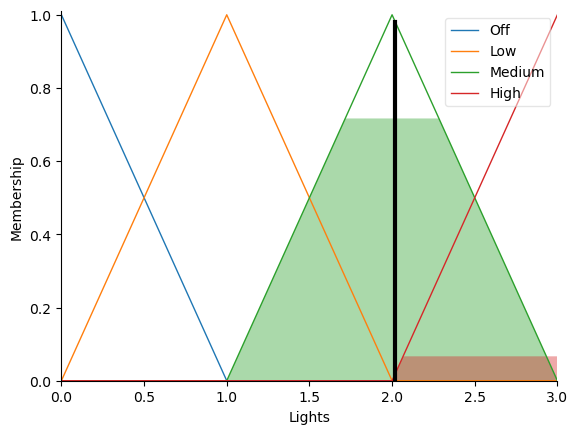

In [334]:
showResult(lights, 'Lights', lights_membership, lights_membership_str)

Fans: 0.3541847041847041
Status: Off


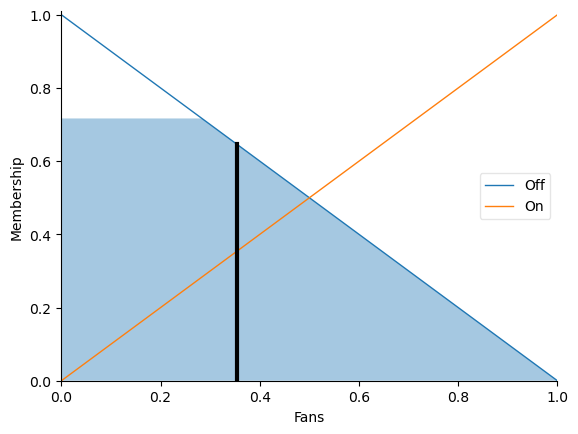

In [335]:
showResult(fans, 'Fans', fans_membership, fans_membership_str)

pH Control: 1.542851171816689
Status: Add Alkali


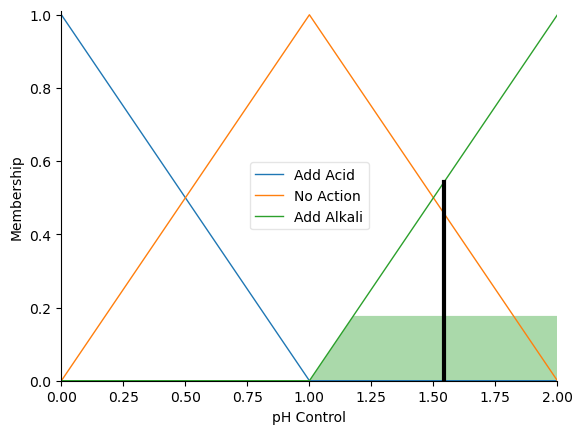

In [336]:
showResult(pH_control, 'pH Control', pH_membership, pH_membership_str)

Solution Control: 1.5743263614094596
Status: Add Water


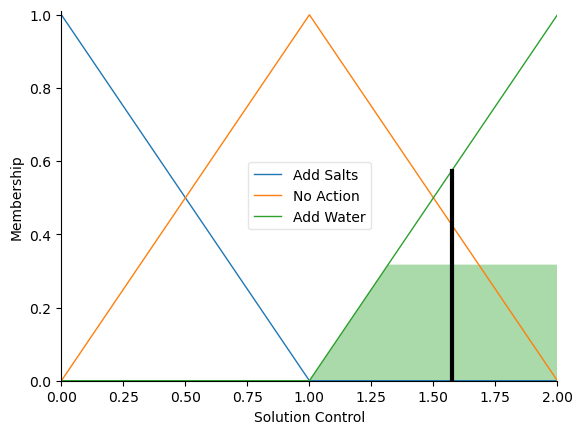

In [337]:
showResult(solution_control, 'Solution Control', ec_membership, ec_membership_str)

In [338]:
def postData(lights_val, fans_val, pH_control_val, ec_control_val):
    URL = 'https://api.thingspeak.com/update?api_key='
    HEADER = '&field1={}&field2={}&field3={}&field4={}'.format(lights_val, fans_val, pH_control_val, ec_control_val)
    API_KEY = 'CRRZ0O3AA7YZ1UU5'
    NEW_URL = URL+API_KEY+HEADER
    return requests.get(NEW_URL)

In [339]:
postData(lights_membership, fans_membership, pH_membership, ec_membership)

<Response [200]>

In [340]:
def loop():
    data = getFeed()
    air = getAirTemp(data)
    humid = getHumidity(data)
    pH_level = getPH(data)
    ec_level = getEC(data)
    run(air, humid, pH_level, ec_level)
    lights_membership, fans_membership, pH_membership, ec_membership, lights_membership_str, fans_membership_str, pH_membership_str, ec_membership_str = getResults()
    postData(lights_membership, fans_membership, pH_membership, ec_membership)
    memberships = [[air, humid, pH_level, ec_level, lights_membership, fans_membership, pH_membership, ec_membership, lights_membership_str, fans_membership_str, pH_membership_str, ec_membership_str]]
    ctrlSim.reset()
    return memberships

In [341]:
# memberships = [['Air Temperature','Humidity','pH', 'Conductivity', 'Lights Membership', 'Fans Membership', 'pH Membership', 'EC Membership', 'Lights Status', 'Fans Status', 'pH Control Status', 'EC Control Status']]
# with open('results.csv', 'w', encoding='UTF8') as f:
#         writer = csv.writer(f)
#         writer.writerow(memberships)
#         f.close()

In [342]:
timeout = time.time() + 60 * 60  # 120 minutes from now
while time.time() < timeout:
    with open('results.csv', 'a', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerows(loop())
        f.close()
    time.sleep(5)